In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

Notation: 
* SF = scale free
* ER = Erdosh Renyi

In [181]:
### PARAMETERS ###
N = 1000
k0 = 2
p_mob = 0.05
eps = 0.1
beta = 0.09
mu = 0.05 # change this, it's the most unreasonable estimate
gamma = 0.01

In [143]:
G_sf = nx.barabasi_albert_graph(N,k0) #number of nodes, number of links added for each node
mean_deg_sf = sum([k for i, k in G_sf.degree()])/len(G_sf.degree())
print("K0: \t", k0)
print("Kmean: ", mean_deg_sf)

K0: 	 2
Kmean:  3.992


In [144]:
p = k0/N*2 # prob of creating an edge
G_er = nx.binomial_graph(N,p)
mean_deg_er = sum([k for i, k in G_er.degree()])/len(G_er.degree())
print("Kmean: ", mean_deg_er)

Kmean:  4.174


Now we get the adjacency matrices

In [145]:
A_sf = nx.to_numpy_matrix(G_sf)
A_er = nx.to_numpy_matrix(G_er)

In [154]:
def SIRS_step(A, state, beta, mu, gamma, T=0.5, debug=True):
    """
    SIRS step for a single network. Updated A and state needs to be computed
    before calling this function (take into account mobility + dynamic contacts).
    Works with synchronous update (e.g. new infected cannot recover in this step).
    
    Parameters
    ----------
    - A : adjacency matrix
    - state : 
        state[:,0] = 1 for the susceptible, 0 for the others
        state[:,1] = 1 for the infected, 0 for the others
        state[:,2] = 1 for the recovered, 0 for the others
    - beta : prob of infection given contact
    - mu : prob of recovery per step
    - gamma : prob of S->R transition per step
    - T : fraction of the day spent in the system
    
    Return
    ------
    state, recovered (updated)
    """
    N = len(state)
    new_state = np.zeros((N,3))
    
    dprint = print if debug else lambda *args, **kwargs : None
        
    ### S -> I ###
    p_I = beta*np.matmul(A,state[:,1]).T # prob of getting the infection
    p_I = np.array(p_I).reshape(N)
    u = np.random.rand(N) 
    mask_S = (u < p_I*state[:,0]) # apply only to susceptible
    new_state[mask_S,1] = 1
    state[mask_S,0] = 0
    
    dprint("New I: ", new_state[:,1].sum())
    
    ### I -> R ###
    u = np.random.rand(N) 
    mask_I = (u < mu*state[:,1]) # apply only to infected
    new_state[mask_I,2] = 1
    state[mask_I,1] = 0
    
    dprint("New R: ", new_state[:,2].sum())
    
    ### R -> S ###
    u = np.random.rand(N) 
    mask_R = (u < gamma*state[:,2]) # apply only to recovered
    new_state[mask_R,0] = 1
    state[mask_R,2] = 0
    
    dprint("New S: ", new_state[:,0].sum())
    
    state = state + new_state
    
    dprint("Updated S: ", state[:,0].sum())
    dprint("Updated I: ", state[:,1].sum())
    dprint("Updated R: ", state[:,2].sum())
    
    return state

Comments: the computation for the probability of getting infected works only at the beginning of the infection, then it overestimates the infection strength.

In [186]:
# TEST
N = 1000
I0 = 5

G_test = nx.barabasi_albert_graph(N,4)
A_test = nx.to_numpy_matrix(G_test)

# prepare initial state
susceptible = np.ones(N)
seeds = np.random.choice(np.arange(N), size = I0)
susceptible[seeds] = 0
state = np.zeros((N,3))
state[:,0] = susceptible
state[seeds,1] = 1

In [187]:
import time 
start = time.time()
n_iter = 200
S = []
I = []
R = []
t_vec = []
for i in range(n_iter):
    state = SIRS_step(A_test, state, beta, mu, gamma, T=1, debug=False)
    S.append(state[:,0].sum())
    I.append(state[:,1].sum())
    R.append(state[:,2].sum())
    t_vec.append(time.time()-start)
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))
S = np.array(S)
I = np.array(I)
R = np.array(R)
t_vec = np.array(t_vec)

Total time elapsed: 0.51 s
Time per iteration: 0.0025 s


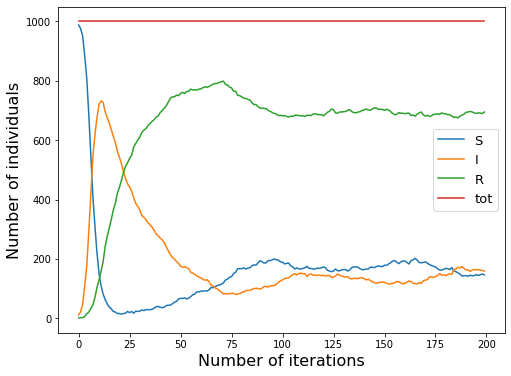

In [188]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S, label = 'S')
plt.plot(indexes, I, label = 'I')
plt.plot(indexes, R, label = 'R')
plt.plot(indexes, S+I+R, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13)
plt.show()